In [1]:
import numpy as np
import networkx as nx
import matplotlib.pyplot as plt



In [2]:
# import old work

from session15 import get_session15_endomaps
XG,YG = get_session15_endomaps()

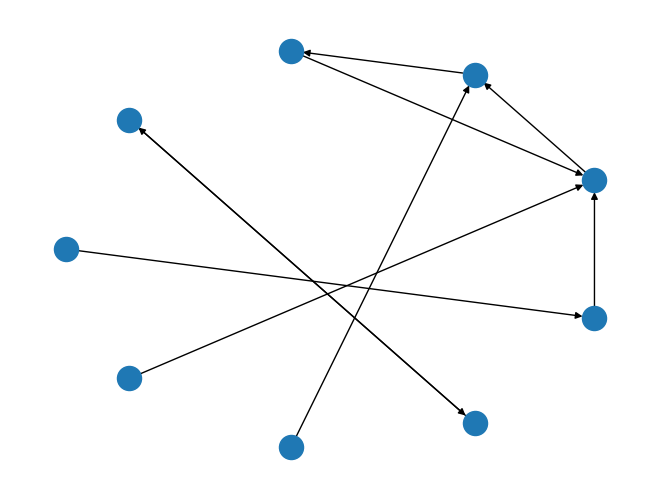

In [3]:
nx.draw_shell(XG)

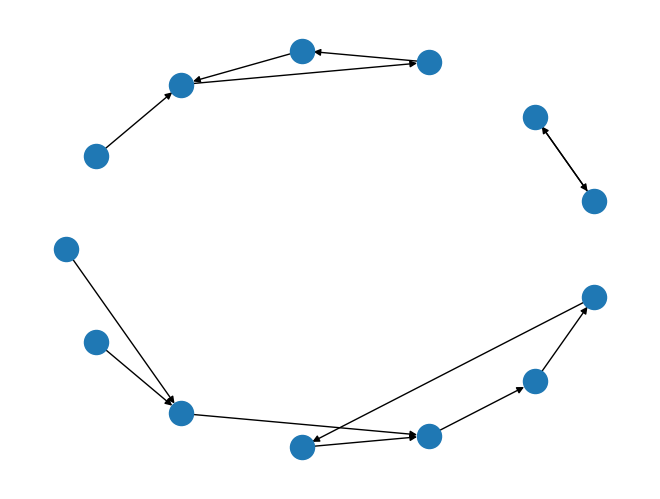

In [4]:
nx.draw_shell(YG)

In [5]:
def make_cycle(n):
    nodes = range(n)
    edges = [(i,(i+1)%n) for i in nodes]
    G = nx.DiGraph()
    G.add_nodes_from(nodes)
    G.add_edges_from(edges)
    return G


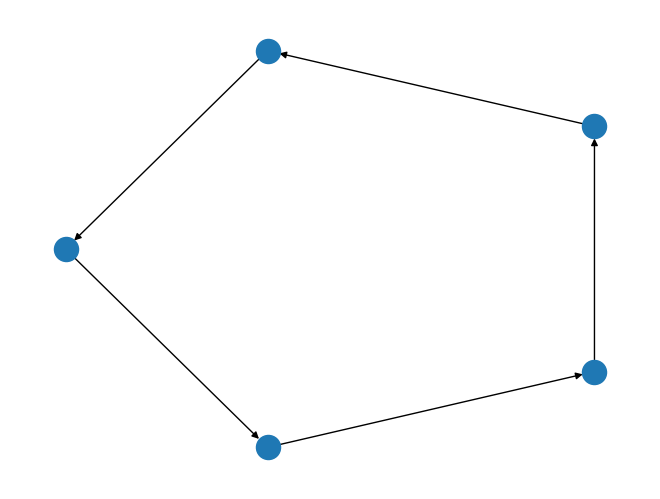

In [6]:
nx.draw_shell(make_cycle(5))

In [7]:
def make_tail(n):
    nodes = range(n+1)
    edges = [(i+1,i) for i in range(n)]
    G = nx.DiGraph()
    G.add_nodes_from(nodes)
    G.add_edges_from(edges)
    return G

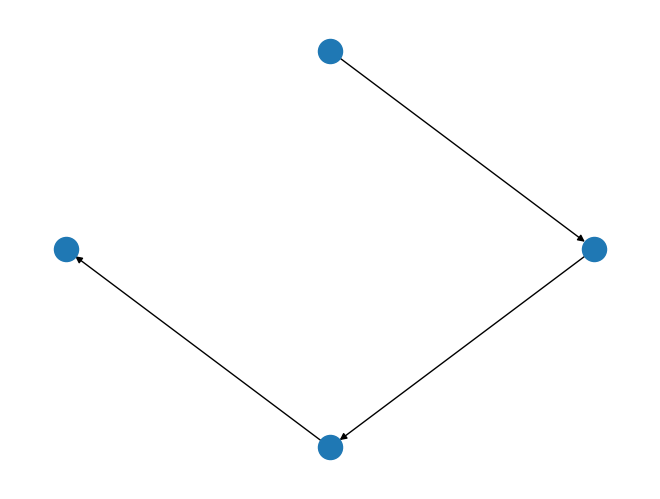

In [8]:
nx.draw_shell(make_tail(3))

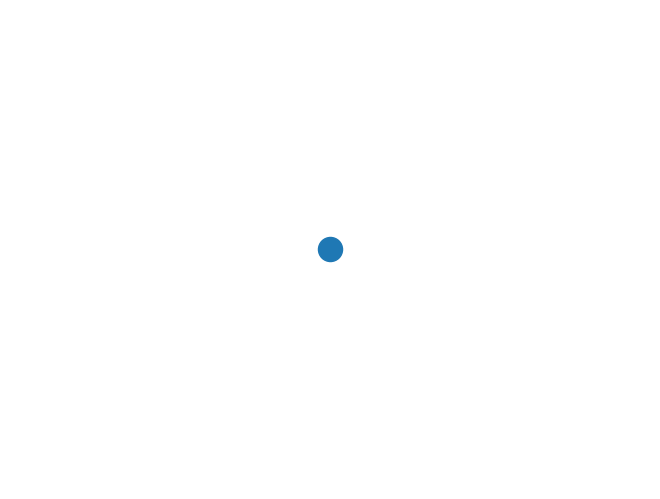

In [9]:
nx.draw_shell(make_tail(0))

In [10]:
# so, here's my idea
# instead of looking at points of x as single values, look at them as triples (s,r,t)
XN = list(XG.nodes)
XL = len(XN)
XR = {j:i for i,j in enumerate(XN)}
print(f"{XL} elements: {XR}")


9 elements: {'X0': 0, 'X1': 1, 'X2': 2, 'X3': 3, 'X4': 4, 'X5': 5, 'X6': 6, 'X7': 7, 'X8': 8}


In [11]:
XRE = [{"s":XR[j[0]],"t":XR[j[1]]} for j in list(XG.edges)]
print(f"{len(XRE)} arrows {XRE}")

9 arrows [{'s': 0, 't': 4}, {'s': 1, 't': 5}, {'s': 2, 't': 6}, {'s': 3, 't': 8}, {'s': 4, 't': 5}, {'s': 5, 't': 6}, {'s': 6, 't': 7}, {'s': 7, 't': 5}, {'s': 8, 't': 3}]


In [12]:
from session15 import zig_zag, reverse_zig_zag
list(zig_zag(4))

[(0, 0), (0, 1), (1, 0), (0, 2)]

In [13]:
reverse_zig_zag((0,4))

10

In [14]:
arrow_space = [reverse_zig_zag((a["s"],a["t"])) for a in XRE]
print(arrow_space)

[10, 22, 38, 69, 49, 71, 97, 85, 74]


In [15]:
arrow_retractions = [reverse_zig_zag((a["t"],a["s"])) for a in XRE]
print(arrow_retractions)

[14, 26, 42, 74, 50, 72, 98, 83, 69]


In [16]:
f_1 = {arrow_space[i]:arrow_retractions[i] for i in range(XL)}
f_2 = {arrow_retractions[i]:arrow_space[i] for i in range(XL)}
print(f"Arrows of A->B {f_1}\nArrows of B->A {f_2}")

Arrows of A->B {10: 14, 22: 26, 38: 42, 69: 74, 49: 50, 71: 72, 97: 98, 85: 83, 74: 69}
Arrows of B->A {14: 10, 26: 22, 42: 38, 74: 69, 50: 49, 72: 71, 98: 97, 83: 85, 69: 74}


In [17]:
def compose_maps(f,g):
    return {
        k:g[v] for k,v in zip(f.keys(),f.values())
    }

In [18]:
print(compose_maps(f_1,f_2))
print(compose_maps(f_2,f_1))

{10: 10, 22: 22, 38: 38, 69: 69, 49: 49, 71: 71, 97: 97, 85: 85, 74: 74}
{14: 14, 26: 26, 42: 42, 74: 74, 50: 50, 72: 72, 98: 98, 83: 83, 69: 69}


In [19]:
# theoretically, we should be able to enumerate possible fixed points this way
[reverse_zig_zag((i,i)) for i in range(10)]


[0, 4, 12, 24, 40, 60, 84, 112, 144, 180]

In [20]:
# so there should be a unique composition where these maps are align
# map the points to (s,s) pairs, then send those to (f_1,f_2) 

In [21]:
X_normalized = [
    {
        "s":reverse_zig_zag((i,i)),
        "t":reverse_zig_zag((arrow_space[i],arrow_retractions[i]))
    } for i in range(XL)
]
print(X_normalized)

[{'s': 0, 't': 310}, {'s': 4, 't': 1198}, {'s': 12, 't': 3278}, {'s': 24, 't': 10365}, {'s': 40, 't': 4999}, {'s': 60, 't': 10367}, {'s': 84, 't': 19207}, {'s': 112, 't': 14281}, {'s': 144, 't': 10370}]


In [22]:
# let's see if we can use nx to find my "inoming arrow count"
incidence_degree = [(XG.degree(i)) for i in XN]
print(list(zip(XN,incidence_degree)))

[('X0', 1), ('X1', 1), ('X2', 1), ('X3', 2), ('X4', 2), ('X5', 4), ('X6', 3), ('X7', 2), ('X8', 2)]


In [23]:
# oooooh that's interesting
# networkx starts counting at 1 rather than 0 like I have been
# old C++ habits die hard i guess
#lets check y also
{j:YG.degree(j) for j in YG.nodes}

{'Yp': 1,
 'Yq': 1,
 'Yr': 3,
 'Ys': 2,
 'Yt': 3,
 'Yv': 2,
 'Yu': 2,
 'Ym': 2,
 'Yl': 2,
 'Yw': 2,
 'Yx': 2,
 'Yy': 3,
 'Yz': 1}

In [24]:
# let's try to abstract the process
def translate_to_arrow_space(G):
    nodes = list(G.nodes)
    size = len(nodes)
    retract_node = {j:i for i,j in enumerate(nodes)}
    arrows = [{
            "s":retract_node[j[0]],
            "t":retract_node[j[1]]
    } for j in list(G.edges)]
    G_alpha = {
        i:reverse_zig_zag((a["s"],a["t"])) for i,a in enumerate(arrows)
    }
    print(G_alpha)
    points = {
        i:reverse_zig_zag((retract_node[a],retract_node[a])) for i,a in enumerate(nodes)
    }
    print(points)
    print(compose_maps(retract_node,points))
    G_s_t = [
        {
            "s":points[a["s"]],
            "t":reverse_zig_zag((points[a["s"]],G_alpha[a["t"]]))
        } for a in arrows
    ]
    return G_s_t

XG_A = translate_to_arrow_space(XG)
print(XG_A)

{0: 10, 1: 22, 2: 38, 3: 69, 4: 49, 5: 71, 6: 97, 7: 85, 8: 74}
{0: 0, 1: 4, 2: 12, 3: 24, 4: 40, 5: 60, 6: 84, 7: 112, 8: 144}
{'X0': 0, 'X1': 4, 'X2': 12, 'X3': 24, 'X4': 40, 'X5': 60, 'X6': 84, 'X7': 112, 'X8': 144}
[{'s': 0, 't': 1225}, {'s': 4, 't': 2854}, {'s': 12, 't': 6007}, {'s': 24, 't': 4875}, {'s': 40, 't': 6256}, {'s': 60, 't': 12463}, {'s': 84, 't': 14449}, {'s': 112, 't': 16948}, {'s': 144, 't': 22935}]


In [25]:
# lets see Y also
YG_A = translate_to_arrow_space(YG)
print(YG_A)

{0: 3, 1: 7, 2: 23, 3: 31, 4: 49, 5: 71, 6: 51, 7: 127, 8: 128, 9: 199, 10: 241, 11: 221, 12: 288}
{0: 0, 1: 4, 2: 12, 3: 24, 4: 40, 5: 60, 6: 84, 7: 112, 8: 144, 9: 180, 10: 220, 11: 264, 12: 312}
{'Yp': 0, 'Yq': 4, 'Yr': 12, 'Ys': 24, 'Yt': 40, 'Yv': 60, 'Yu': 84, 'Ym': 112, 'Yl': 144, 'Yw': 180, 'Yx': 220, 'Yy': 264, 'Yz': 312}
[{'s': 0, 't': 276}, {'s': 4, 't': 382}, {'s': 12, 't': 1903}, {'s': 24, 't': 2725}, {'s': 40, 't': 6256}, {'s': 60, 't': 6276}, {'s': 84, 't': 6754}, {'s': 112, 't': 29032}, {'s': 144, 't': 37000}, {'s': 180, 't': 89011}, {'s': 220, 't': 97681}, {'s': 264, 't': 107680}, {'s': 312, 't': 142623}]


In [26]:
def map_N_x_N_to_N(a):
    return reverse_zig_zag((a["s"],a["t"]))
map_N_x_N_to_N(XG_A[0])

750925

In [27]:
XG_A1 = list(map(map_N_x_N_to_N,XG_A))
print(XG_A1)

[750925, 4085515, 18117202, 12002574, 19822996, 78419086, 105611395, 145530442, 266331804]


In [28]:
YG_A1 = list(map(map_N_x_N_to_N,YG_A))
print(YG_A1)

[38226, 74695, 1834582, 3779899, 19822996, 20075676, 23382625, 424701052, 689857084, 3977562016, 4792352071, 5826007804, 10215278892]


In [29]:
# do these have any points in common?
intersection = list(set(XG_A1)&set(YG_A1))
print(intersection)

[19822996]


In [30]:
# yes! exactly one
X_I = XG_A1.index(intersection[0])
Y_I = YG_A1.index(intersection[0])
print(f"x_i:{X_I}. y_i:{Y_I}")

x_i:4. y_i:4


In [31]:
print(XG_A[X_I])
print(YG_A[Y_I])

{'s': 40, 't': 6256}
{'s': 40, 't': 6256}


In [32]:
# the points that match are "X4" and "Yt"
print(XG.degree(XN[X_I]))
print(YG.degree(list(YG.nodes)[Y_I]))

2
3


In [33]:
# these don't seem to have any special qualities in common
# unless we consider that they both have 4 generators?
from session15 import make_presentation
X_pres = make_presentation(XG)
print(X_pres)
Y_pres = make_presentation(YG)
print(Y_pres)


{'generators': ['X0', 'X1', 'X2', 'X3'], 'relations': [(('X0', 5), ('X0', 2)), (('X1', 1), ('X0', 2)), (('X2', 1), ('X0', 3)), (('X3', 2), ('X3', 0))]}
{'generators': ['Yp', 'Yq', 'Yz', 'Ym'], 'relations': [(('Yp', 6), ('Yp', 2)), (('Yq', 1), ('Yp', 1)), (('Yz', 4), ('Yz', 1)), (('Ym', 2), ('Ym', 0))]}


In [34]:
# I wonder if there's a connection here with my "standardized presentation"?
from session15 import standardize_presentation
X_pres_std = standardize_presentation(X_pres)
print(X_pres_std)
Y_pres_std = standardize_presentation(Y_pres)
print(Y_pres_std)


{'generator_count': 4, 'generators': ['X0', 'X1', 'X2', 'X3'], 'substitutions': {15: 3, 4: 3, 8: 6, 18: 9}, 'relation_pairs': {15: ('X0', 5), 3: ('X0', 2), 4: ('X1', 1), 8: ('X2', 1), 6: ('X0', 3), 18: ('X3', 2), 9: ('X3', 0)}, 'max_depth': 5, 'max_steps': 18}
{'generator_count': 4, 'generators': ['Yp', 'Yq', 'Yz', 'Ym'], 'substitutions': {21: 3, 4: 1, 23: 8, 18: 9}, 'relation_pairs': {21: ('Yp', 6), 3: ('Yp', 2), 4: ('Yq', 1), 1: ('Yp', 1), 23: ('Yz', 4), 8: ('Yz', 1), 18: ('Ym', 2), 9: ('Ym', 0)}, 'max_depth': 6, 'max_steps': 23}


In [35]:
# the authors mention a sense in which the presentation was minimal,
# but it's hard to tell if if I have it it here
# let's go back to these arrow maps and see what else we can work with

for i in range(5):
    A_i = make_tail(i)
    A_s_t = translate_to_arrow_space(A_i)
    print(f"A_{i}:\t{A_i}\n\t\t{list(A_i.edges)}\n\t{A_s_t}")
    print(list(map(map_N_x_N_to_N,A_s_t)))

for i in range(5):
    C_i = make_cycle(i)
    C_s_t = translate_to_arrow_space(C_i)
    print(f"C_{i}:\t{C_i}\n\t\t{list(C_i.edges)}\n\t {C_s_t}")
    print(list(map(map_N_x_N_to_N,C_s_t)))

{}
{0: 0}
{0: 0}
A_0:	DiGraph with 1 nodes and 0 edges
		[]
	[]
[]
{0: 2}
{0: 0, 1: 4}
{0: 0, 1: 4}
A_1:	DiGraph with 2 nodes and 1 edges
		[(1, 0)]
	[{'s': 4, 't': 25}]
[439]
{0: 2, 1: 8}
{0: 0, 1: 4, 2: 12}
{0: 0, 1: 4, 2: 12}
A_2:	DiGraph with 3 nodes and 2 edges
		[(1, 0), (2, 1)]
	[{'s': 4, 't': 25}, {'s': 12, 't': 222}]
[439, 27507]
{0: 2, 1: 8, 2: 18}
{0: 0, 1: 4, 2: 12, 3: 24}
{0: 0, 1: 4, 2: 12, 3: 24}
A_3:	DiGraph with 4 nodes and 3 edges
		[(1, 0), (2, 1), (3, 2)]
	[{'s': 4, 't': 25}, {'s': 12, 't': 222}, {'s': 24, 't': 927}]
[439, 27507, 452700]
{0: 2, 1: 8, 2: 18, 3: 32}
{0: 0, 1: 4, 2: 12, 3: 24, 4: 40}
{0: 0, 1: 4, 2: 12, 3: 24, 4: 40}
A_4:	DiGraph with 5 nodes and 4 edges
		[(1, 0), (2, 1), (3, 2), (4, 3)]
	[{'s': 4, 't': 25}, {'s': 12, 't': 222}, {'s': 24, 't': 927}, {'s': 40, 't': 2668}]
[439, 27507, 452700, 3668026]
{}
{}
{}
C_0:	DiGraph with 0 nodes and 0 edges
		[]
	 []
[]
{0: 0}
{0: 0}
{0: 0}
C_1:	DiGraph with 1 nodes and 1 edges
		[(0, 0)]
	 [{'s': 0, 't': 0}]
[0

In [36]:
# C_0 here doesn't seem correct either
# it should really be \mathbb{N}
# this map is unique composition I-> N -> C_n -> T
# maybe I can define N=C_0 with a lambda function somehow?

# I think that in order to treat N as an object
# I'll need to step out from the graph to presentation
# let's put that aside for now

# A_0 feels like it's missing an identity map
# something identifying that unique node such that s=t=0
# i'm also wondering if i should reverse the direction
def make_tail(n):
    nodes = range(n+1)
    edges = [(i,min(n,i+1)) for i in nodes]
    G = nx.DiGraph()
    G.add_nodes_from(nodes)
    G.add_edges_from(edges)
    return G
    
for i in range(10):
    A_i = make_tail(i)
    A_s_t = translate_to_arrow_space(A_i)
    print(f"A_{i}:\t{A_i}\n\t\t{list(A_i.edges)}\n\t{A_s_t}")
    print(list(map(map_N_x_N_to_N,A_s_t)))
    

{0: 0}
{0: 0}
{0: 0}
A_0:	DiGraph with 1 nodes and 1 edges
		[(0, 0)]
	[{'s': 0, 't': 0}]
[0]
{0: 1, 1: 4}
{0: 0, 1: 4}
{0: 0, 1: 4}
A_1:	DiGraph with 2 nodes and 2 edges
		[(0, 1), (1, 1)]
	[{'s': 0, 't': 10}, {'s': 4, 't': 40}]
[55, 994]
{0: 1, 1: 7, 2: 12}
{0: 0, 1: 4, 2: 12}
{0: 0, 1: 4, 2: 12}
A_2:	DiGraph with 3 nodes and 3 edges
		[(0, 1), (1, 2), (2, 2)]
	[{'s': 0, 't': 28}, {'s': 4, 't': 140}, {'s': 12, 't': 312}]
[406, 10444, 52662]
{0: 1, 1: 7, 2: 17, 3: 24}
{0: 0, 1: 4, 2: 12, 3: 24}
{0: 0, 1: 4, 2: 12, 3: 24}
A_3:	DiGraph with 4 nodes and 4 edges
		[(0, 1), (1, 2), (2, 3), (3, 3)]
	[{'s': 0, 't': 28}, {'s': 4, 't': 235}, {'s': 12, 't': 678}, {'s': 24, 't': 1200}]
[406, 28684, 238407, 749724]
{0: 1, 1: 7, 2: 17, 3: 31, 4: 40}
{0: 0, 1: 4, 2: 12, 3: 24, 4: 40}
{0: 0, 1: 4, 2: 12, 3: 24, 4: 40}
A_4:	DiGraph with 5 nodes and 5 edges
		[(0, 1), (1, 2), (2, 3), (3, 4), (4, 4)]
	[{'s': 0, 't': 28}, {'s': 4, 't': 235}, {'s': 12, 't': 958}, {'s': 24, 't': 2104}, {'s': 40, 't': 3280

In [37]:
#  the sequence of sources seems intriguing
print(2*2) # 2^2 3^0 5^0 7^0
print(2*2*3) # 2^2 3^1 5^0 7^0
print(2*2*3*2)  # 2^3 3^0 5^0 7^0
print(2*2*2*5) # 2^2 3^0 5^1 7^0
print(2*2*3*5) # 2^2 3^1 5^1 7^0
print(2*2*2*2*7) # 2^4 3^0 5^0 7^1
print(2*2*2*2*3*3) # 2^4 3^2 5^0 7^0
print(2*2*3*3*5) # 2^2 3^2 5^1 7^0

4
12
24
40
60
112
144
180


In [38]:
# maybe i was onto something with prime factors
# Given any C_n, there's a unique map
# from C_n -> C_p1^q1 x C_p2^q2 x ... C_pn^qn -> T
# determined by the unique factorization